In [1]:
import numpy as np
import os
import cv2

#your path 
folder = 'E:/New folder/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02'

In [2]:
import matplotlib.image as mpimg

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            img=cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
            images.append(img)
            
    return images

In [3]:
truth=load_images(folder)

In [4]:
truth=np.array(truth)
truth.shape

(98, 188, 621)

In [5]:
folder1 = 'E:/New folder/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_03'
truth1=np.array(load_images(folder1))
truth=np.append(truth,truth1, axis=0)
truth.shape

(196, 188, 621)

In [6]:
folder2='E:/New folder/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02'
truth2=np.array(load_images(folder2))
truth=np.append(truth,truth2, axis=0)
truth.shape

(629, 188, 621)

In [7]:
folder3='E:/New folder/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_03'
truth3=np.array(load_images(folder3))
truth=np.append(truth,truth3, axis=0)
truth.shape

(1062, 188, 621)

In [8]:
folder4='E:/New folder/train/2011_09_26_drive_0011_sync/proj_depth/groundtruth/image_02'
truth4=np.array(load_images(folder4))
truth=np.append(truth,truth4, axis=0)
truth.shape

(1283, 188, 621)

In [9]:
folder5='E:/New folder/train/2011_09_26_drive_0011_sync/proj_depth/groundtruth/image_03'
truth5=np.array(load_images(folder5))
truth=np.append(truth,truth5, axis=0)
truth.shape

(1506, 188, 621)

In [10]:
folder10 = 'E:/New folder/Data/2011_09_26/2011_09_26_drive_0001_sync/image_02/data'
truth0=load_images(folder10)
truth0=np.array(truth0)
truth0.shape

(98, 188, 621, 3)

In [11]:
folder11 = 'E:/New folder/Data/2011_09_26/2011_09_26_drive_0001_sync/image_03/data'
truth10=np.array(load_images(folder11))
truth0=np.append(truth0,truth10, axis=0)
truth0.shape

(196, 188, 621, 3)

In [12]:
folder12 = 'E:/New folder/Data/2011_09_26/2011_09_26_drive_0011_sync/image_03/data'
truth20=np.array(load_images(folder12))
truth0=np.append(truth0,truth20, axis=0)
truth0.shape

(419, 188, 621, 3)

In [13]:
folder12 = 'E:/New folder/Data/2011_09_26/2011_09_26_drive_0011_sync/image_02/data'
truth20=np.array(load_images(folder12))
truth0=np.append(truth0,truth20, axis=0)
truth0.shape

(640, 188, 621, 3)

In [14]:
folder12 = 'E:/New folder/Data/2011_09_26/2011_09_26_drive_0009_sync/image_03/data'
truth20=np.array(load_images(folder12))
truth0=np.append(truth0,truth20, axis=0)
truth0.shape

(1073, 188, 621, 3)

In [15]:
folder12 = 'E:/New folder/Data/2011_09_26/2011_09_26_drive_0009_sync/image_02/data'
truth20=np.array(load_images(folder12))
truth0=np.append(truth0,truth20, axis=0)
truth0.shape

(1506, 188, 621, 3)

In [16]:
import pandas as pd
import numpy as np

import torch

#imports necessary to define a neural network 
import torch.nn as nn
import torch.nn.functional as F

#ensure you are using GPU.
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)
print(device)

dtype = torch.cuda.FloatTensor

truth0=truth0.reshape([1506, 3, 621, 188])
truth=truth.reshape([1506, 1,  188,621])

cuda:0


In [17]:
import math

import torch
import torch.nn as nn
import torchvision


def weights_init(m):
    # Initialize filters with Gaussian random weights
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()


class MeanFieldUpdate(nn.Module):
    """
    Meanfield updating for the features and the attention for one pair of features.
    bottom_list is a list of observation features derived from the backbone CNN.
    update attention map
    a_s <-- y_s * (K_s conv y_S)
    a_s = b_s conv a_s
    a_s <-- Sigmoid(-(a_s + a_s))
    update the last scale feature map y_S
    y_s <-- K conv y_s
    y_S <-- x_S + (a_s * y_s)
    """

    def __init__(self, bottom_send, bottom_receive, feat_num):
        super(MeanFieldUpdate, self).__init__()

        self.atten_f = nn.Conv2d(in_channels=bottom_send + bottom_receive, out_channels=feat_num,
                                 kernel_size=3, stride=1, padding=1)
        self.norm_atten_f = nn.Sigmoid()
        self.message_f = nn.Conv2d(in_channels=bottom_send, out_channels=feat_num, kernel_size=3,
                                   stride=1, padding=1)
        self.Scale = nn.Conv2d(in_channels=feat_num, out_channels=bottom_receive, kernel_size=1, bias=True)

    def forward(self, x_s, x_S):
        # update attention map
        a_s = torch.cat((x_s, x_S), dim=1)
        a_s = self.atten_f(a_s)
        a_s = self.norm_atten_f(a_s)

        # update the last scale feature map y_S
        y_s = self.message_f(x_s)
        y_S = y_s.mul(a_s)  # production
        # scale
        y_S = self.Scale(y_S)
        y_S = x_S + y_S  # eltwise sum
        return y_S

In [18]:
class SAN(nn.Module):
    """
    Based on ResNet-50
    """

    def __init__(self, in_channels=3, feat_num=512, feat_width=80, feat_height=24, pretrained=True):
        super(SAN, self).__init__()

        # backbone Net: ResNet
        pretrained_model = torchvision.models.__dict__['resnet{}'.format(50)](pretrained=pretrained)
        self.channel = in_channels

        self.conv1 = pretrained_model._modules['conv1']
        self.bn1 = pretrained_model._modules['bn1']
        self.relu = pretrained_model._modules['relu']

        self.maxpool = pretrained_model._modules['maxpool']
        self.layer1 = pretrained_model._modules['layer1']
        self.layer2 = pretrained_model._modules['layer2']
        self.layer3 = pretrained_model._modules['layer3']
        self.layer4 = pretrained_model._modules['layer4']

        # generating multi-scale features with the same dimension
        # in paper,  type = 'gaussian'
        self.res4f_dec_1 = nn.ConvTranspose2d(1024, feat_num, kernel_size=4, stride=2, padding=1)
        
        self.res4f_dec_1_relu = nn.ReLU(inplace=True)

        # in paper,  type = 'gaussian'
        self.res5c_dec_1 = nn.ConvTranspose2d(2048, feat_num, kernel_size=8, stride=4, padding=2)
        self.res5c_dec_1_relu = nn.ReLU(inplace=True)

        self.res4f_dec = nn.UpsamplingBilinear2d(size=(feat_height, feat_width))
        self.res3d_dec = nn.UpsamplingBilinear2d(size=(feat_height, feat_width))
        self.res5c_dec = nn.UpsamplingBilinear2d(size=(feat_height, feat_width))

        # add deep supervision for three semantic layers
        self.prediction_3d = nn.Conv2d(feat_num, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.prediction_4f = nn.Conv2d(feat_num, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.prediction_5c = nn.Conv2d(feat_num, out_channels=1, kernel_size=3, stride=1, padding=1)

        # the first meanfield updating
        self.meanFieldUpdate1_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate1_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate1_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # the second meanfield updating
        self.meanFieldUpdate2_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate2_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate2_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # the third meanfield updating
        self.meanFieldUpdate3_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate3_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate3_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # the fourth meanfield updating
        self.meanFieldUpdate4_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate4_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate4_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # the fifth meanfield updating
        self.meanFieldUpdate5_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate5_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate5_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # produce the output
        self.pred_1 = nn.ConvTranspose2d(feat_num, feat_num // 2, kernel_size=4, stride=2, padding=1)
        self.pred_1_relu = nn.ReLU(inplace=True)
        self.pred_2 = nn.ConvTranspose2d(feat_num // 2, feat_num // 4, kernel_size=4, stride=2, padding=1)
        self.pred_2_relu = nn.ReLU(inplace=True)
        self.pred_3 = nn.Conv2d(feat_num // 4, 1, kernel_size=3, stride=1, padding=1)

        # weights init
        self.res4f_dec_1.apply(weights_init)
        self.res5c_dec_1.apply(weights_init)
        self.prediction_3d.apply(weights_init)
        self.prediction_4f.apply(weights_init)
        self.prediction_5c.apply(weights_init)

        self.meanFieldUpdate1_1.apply(weights_init)
        self.meanFieldUpdate1_2.apply(weights_init)
        self.meanFieldUpdate1_3.apply(weights_init)

        self.meanFieldUpdate2_1.apply(weights_init)
        self.meanFieldUpdate2_2.apply(weights_init)
        self.meanFieldUpdate2_3.apply(weights_init)

        self.meanFieldUpdate3_1.apply(weights_init)
        self.meanFieldUpdate3_2.apply(weights_init)
        self.meanFieldUpdate3_3.apply(weights_init)

        self.meanFieldUpdate4_1.apply(weights_init)
        self.meanFieldUpdate4_2.apply(weights_init)
        self.meanFieldUpdate4_3.apply(weights_init)

        self.meanFieldUpdate5_1.apply(weights_init)
        self.meanFieldUpdate5_2.apply(weights_init)
        self.meanFieldUpdate5_3.apply(weights_init)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        res3d = x
        x = self.layer3(x)
        res4f = x
        x = self.layer4(x)
        res5c = x

        # generate multi-scale features with the same dimension,
        res4f_1 = self.res4f_dec_1(res4f)  # 1024 --> 512
        res4f_1 = self.res4f_dec_1_relu(res4f_1)

        res5c_1 = self.res5c_dec_1(res5c)  # 1024 --> 512
        res4f_1 = self.res5c_dec_1_relu(res5c_1)

        res4f = self.res4f_dec(res4f_1)
        res3d = self.res3d_dec(res3d)
        res5c = self.res5c_dec(res5c_1)

        pred_3d = self.prediction_3d(res3d)
        pred_4f = self.prediction_4f(res4f)
        pred_5c = self.prediction_5c(res5c)

        # five meanfield updating
        y_S = self.meanFieldUpdate1_1(res3d, res5c)
        y_S = self.meanFieldUpdate1_2(res4f, y_S)
        y_S = self.meanFieldUpdate1_3(res5c, y_S)

        y_S = self.meanFieldUpdate2_1(res3d, y_S)
        y_S = self.meanFieldUpdate2_2(res4f, y_S)
        y_S = self.meanFieldUpdate2_3(res5c, y_S)

        y_S = self.meanFieldUpdate3_1(res3d, y_S)
        y_S = self.meanFieldUpdate3_2(res4f, y_S)
        y_S = self.meanFieldUpdate3_3(res5c, y_S)

        y_S = self.meanFieldUpdate4_1(res3d, y_S)
        y_S = self.meanFieldUpdate4_2(res4f, y_S)
        y_S = self.meanFieldUpdate4_3(res5c, y_S)

        y_S = self.meanFieldUpdate5_1(res3d, y_S)
        y_S = self.meanFieldUpdate5_2(res4f, y_S)
        y_S = self.meanFieldUpdate5_3(res5c, y_S)

        pred = self.pred_1(y_S)
        pred = self.pred_1_relu(pred)
        pred = self.pred_2(pred)
        pred = self.pred_2_relu(pred)
        pred = self.pred_3(pred)

        pred = nn.functional.interpolate(pred, size=(188,621), mode='bilinear', align_corners=True)

        return pred

In [19]:
model = SAN(feat_width=80, feat_height=24)
model = model.cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

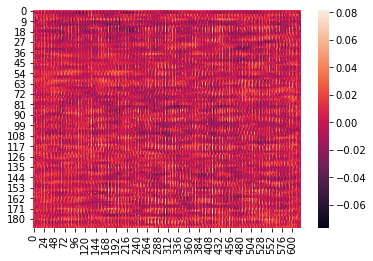

In [20]:
trdttensorc=torch.from_numpy(truth0[0:2,:,:,:]).type(dtype)
import seaborn as sns

ac=model(torch.reshape(trdttensorc[1,:],[1,3,621,188])).detach().cpu().numpy()
sns.heatmap(ac.reshape(188,621))

In [21]:
#trainingloop
torch.cuda.empty_cache()
import torch.optim as optim

lr = 0.1
batchsize=2

batches=1506/batchsize

epochs=30000

# create your optimizer
optimizer = optim.Adam(model.parameters(), lr)

losse=0
for i in range(epochs):
    
    print(losse,i)
    losse=0
    torch.cuda.empty_cache()
    for j in range(int(batches)):
        
        #forward pass
        
        trdttensor=torch.from_numpy(truth0[j:j+batchsize,:,:,:]).type(dtype)
        resultstensor=torch.from_numpy(truth[j:j+batchsize,:,:,:]).type(dtype)
        
        out=model(trdttensor).type(dtype)
        #compute loss
        criterion = nn.MSELoss()
        loss = criterion(out,resultstensor).type(dtype)
        
        
        optimizer.zero_grad()
        #backprop loss i.e. find dloss/dparam for each parameter and store.
        loss.backward(retain_graph=True)
        
        #use optimiser to update
        optimizer.step()
        losse=losse+loss.detach().cpu().numpy()
        del loss
        del trdttensor
        del resultstensor
        torch.cuda.empty_cache()
        
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    a=model(torch.reshape(torch.from_numpy(truth0[0,:,:,:]).type(dtype),[1,3,621,188])).detach().cpu().numpy()
    sns.heatmap(a.reshape(188,621))
    
    plt.show()
    del a 

0 0


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 8.00 GiB total capacity; 4.34 GiB already allocated; 243.73 MiB free; 5.49 GiB reserved in total by PyTorch)

In [ ]:
import seaborn as sns

a=model(torch.reshape(trdttensor[0,:],[1,3,621,188])).detach().cpu().numpy()
a.shape

In [ ]:
sns.heatmap(a.reshape(188,621))

In [ ]:
b=torch.reshape(resultstensor[0,:],[1,1,621,188]).detach().cpu().numpy()
sns.heatmap(b.reshape(188,621))

In [ ]:
sum(p.numel() for p in model.parameters())